# Target

The links below show the quick look lightcurve reduced using a K2 data pipeline called [K2SFF](https://archive.stsci.edu/prepds/k2sff/) available online.

* 	[EPIC212099230](https://exofop.ipac.caltech.edu/k2/edit_target.php?id=212099230)

In [2]:
!python --version

Python 3.6.1 :: Continuum Analytics, Inc.


In [3]:
import os
os.environ['CONDA_DEFAULT_ENV']

'astroconda35'

# K2-C5/C16 lightcurve using K2SFF

In [4]:
import pandas as pd

campaign=str(5)
epic = '212099230'

part1='http://archive.stsci.edu/missions/hlsp/k2sff/c0'
part2='00000/'
part3='/hlsp_k2sff_k2_lightcurve_'
part4='_kepler_v1'

#types of available files
part5=['_llc-default-aper.txt',
      '_llc.fits',
      '_llc.png',
      '_image.png',
      '_correction.png',
      '_skypos.png',
      'medians.png']

url=part1+campaign+'/'+epic[:4]+part2+epic[-5:]+part3+epic+'-c0'+campaign+part4+part5[0]

#
df = pd.read_csv(url, sep=",", header=0, index_col=False)
df.head()

,BJD - 2454833,Corrected Flux
0,2307.550391,0.999898
1,2307.570823,0.999923
2,2307.591255,0.999968
3,2307.611687,1.000019
4,2307.632119,0.999937


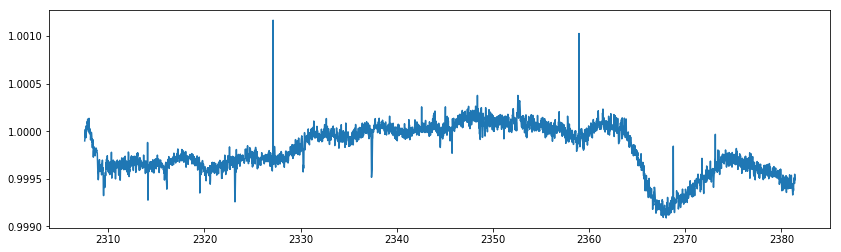

In [5]:
import matplotlib.pyplot as pl

%matplotlib inline

t = df['BJD - 2454833']
f = df[' Corrected Flux']

fig = pl.figure(figsize=(14,4))

pl.plot(t,f,'-')

In [6]:
import everest
everest.__version__

'2.0.9'

## De-trended lightcurve using K2SFF

In [7]:
#styling
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams

rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20
rcParams['ytick.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 'large'

## removing outliers

In [8]:
def apply_mask(self, x=None):
    '''
    Returns the outlier mask, an array of indices corresponding to the
    non-outliers.

    :param numpy.ndarray x: If specified, returns the masked version of \
           :py:obj:`x` instead. Default :py:obj:`None`

    '''

    if x is None:
        return np.delete(np.arange(len(self.time)), self.mask)
    else:
        return np.delete(x, self.mask, axis=0)

In [9]:
from astropy.stats import sigma_clip
import numpy as np

m=sigma_clip(f, sigma_lower=3, sigma_upper=3)

t_c = t[~m.mask]
f_c = f[~m.mask]
n_outliers = np.sum(m.mask)
n_outliers

2

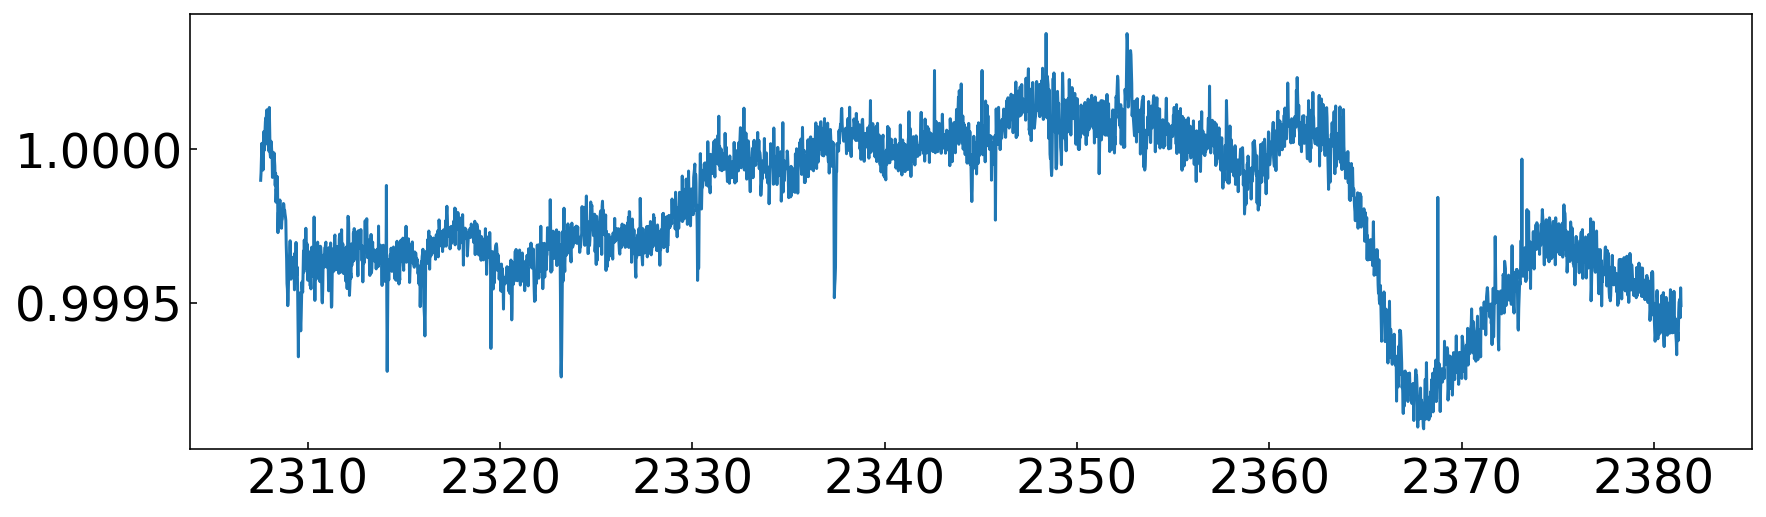

In [10]:
fig = pl.figure(figsize=(14,4))

pl.plot(t_c,f_c,'-')

## fit stellar variability

### analytically (linalg)

In [11]:
import numpy as np

def compute_w(vecs,y):
    #unpack n-dimensional vector
    X=np.c_[np.atleast_2d(vecs).T]
    try:
        w = np.linalg.solve(np.dot(X.T,X), np.dot(X.T, y))
    except:
        #if matrix is singular/ non-invertible
        w=np.linalg.lstsq(X,y, rcond=None)
    return w, X

In [12]:
order = 50
ti = t_c - t_c.mean()
v = [ti**i for i in range(order)]

#normalize flux
ff = f_c/np.median(f_c)
w,X = compute_w(v,ff)

#coefficients
w

array([ 1.00024555e+00, -4.71391748e-06,  2.80297611e-06,  1.11306050e-06,
       -1.11732392e-07, -2.21338742e-08,  1.80113116e-09,  1.70457343e-10,
       -1.51965671e-11, -6.01647457e-13,  6.92841980e-14,  8.53494522e-16,
       -1.69062692e-16,  4.08175905e-19,  1.87478748e-19, -2.77601251e-21,
        8.83166525e-24,  3.23387080e-24, -1.78085544e-25, -2.28670653e-27,
        7.30508678e-30,  3.01576486e-30,  1.69697041e-31, -1.99332957e-33,
       -1.63593249e-35, -1.84259162e-36, -7.91043274e-38,  8.85310153e-40,
       -1.85174725e-41,  2.32382449e-42, -1.02210490e-44,  1.15180541e-46,
        5.10764759e-47, -2.10139297e-48,  2.00444534e-50, -3.12221795e-52,
       -1.07759161e-53,  8.31440665e-55, -2.75572169e-56,  3.43437598e-58,
       -1.16776690e-59,  1.22791367e-61,  2.67935056e-62, -4.74807502e-64,
        1.60047998e-66, -4.91828097e-68, -9.99948963e-69,  2.14968731e-70,
        2.75308264e-72, -5.97986434e-74])

In [13]:
yhat = np.dot(X,w)
np.allclose(yhat,ff, rtol=1e-1)

True

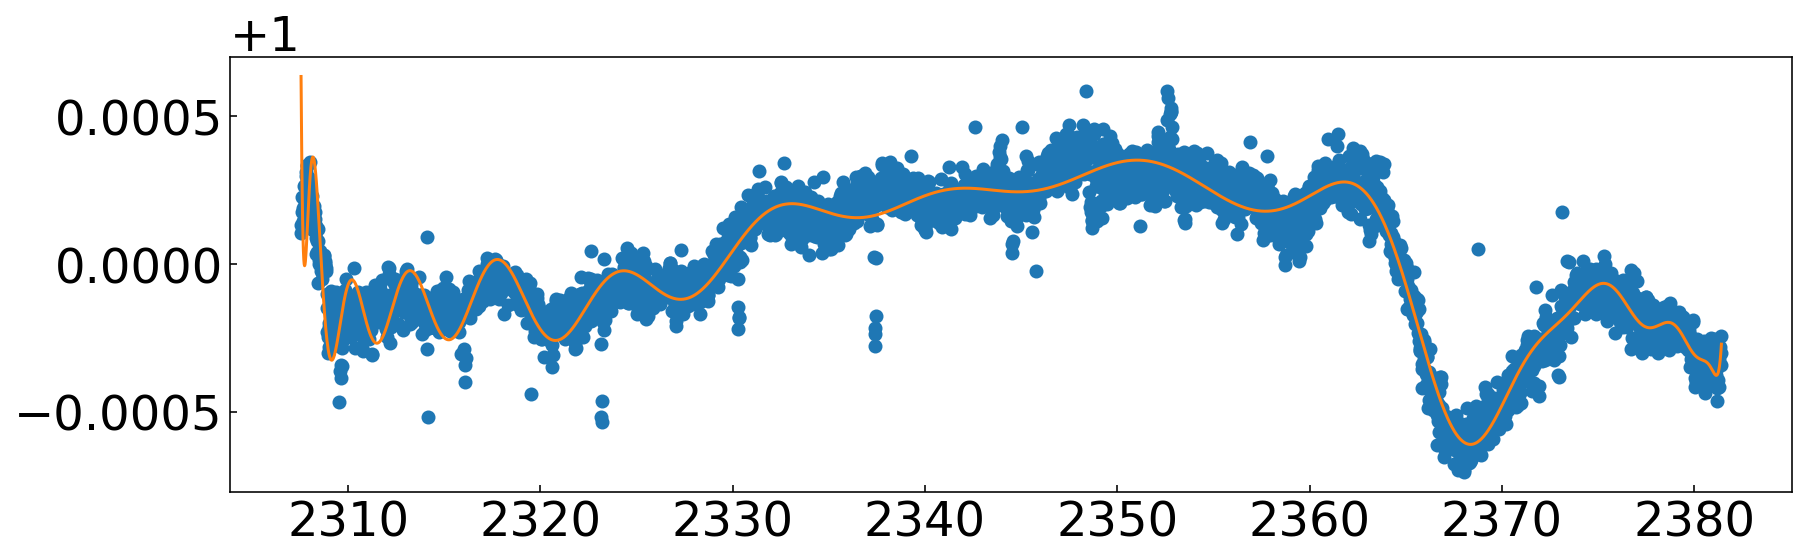

In [14]:
fig = pl.figure(figsize=(14,4))

pl.plot(t_c,ff,'o')
pl.plot(t_c,yhat,'-')

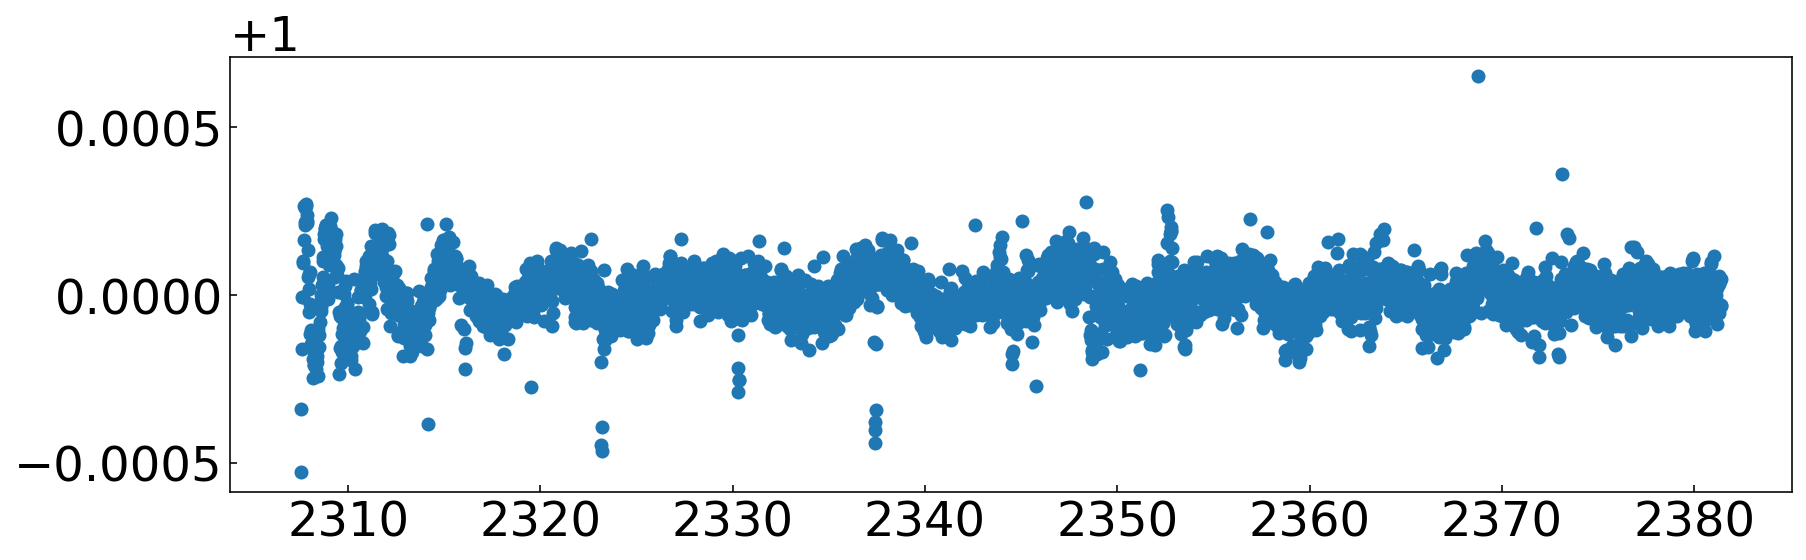

In [15]:
fig = pl.figure(figsize=(14,4))

f_d = ff/yhat
pl.plot(t_c,f_d,'o')
#pl.ylim(0.999,1.001)

### using median filter

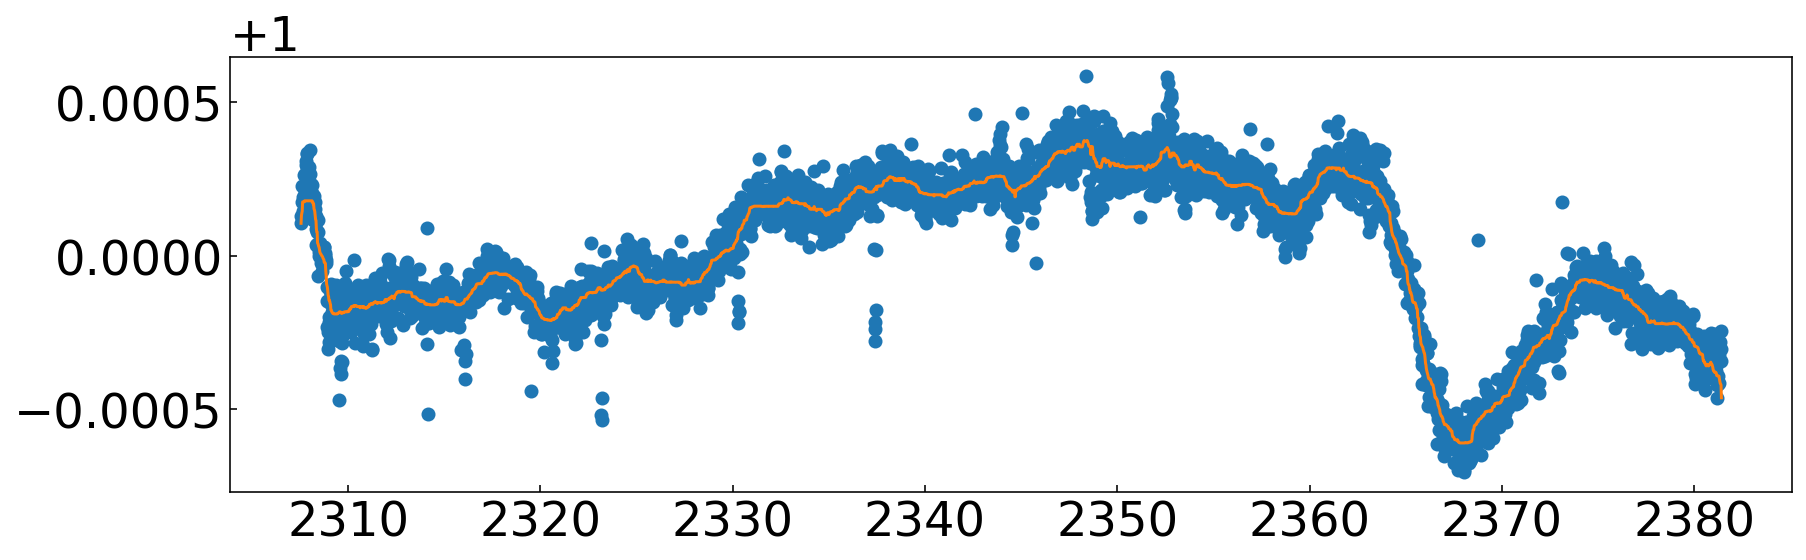

In [38]:
from scipy.signal import medfilt

fig = pl.figure(figsize=(14,4))

yhat = medfilt(ff, kernel_size=51)

pl.plot(t_c,ff,'o')
pl.plot(t_c,yhat)

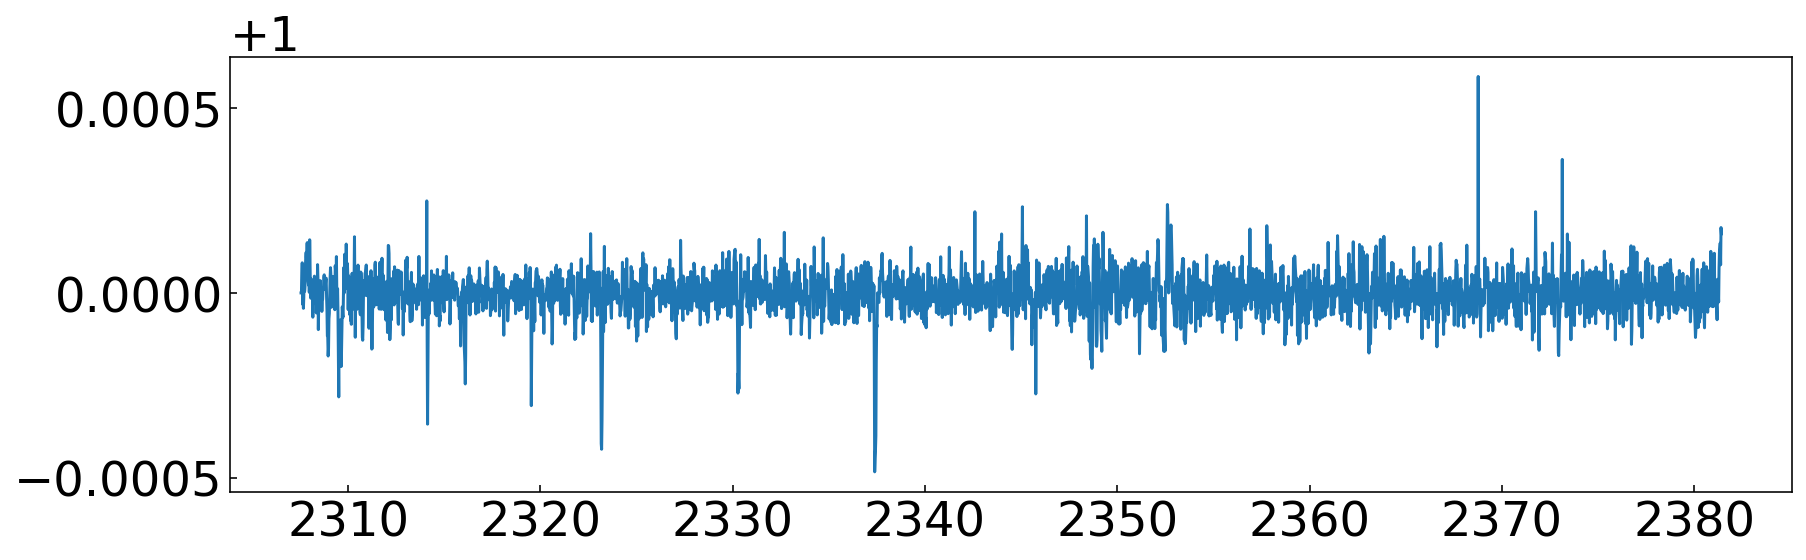

In [35]:
fig = pl.figure(figsize=(14,4))

f_d = ff/yhat
pl.plot(t_c,f_d,'-')

### interpolation with Rbf

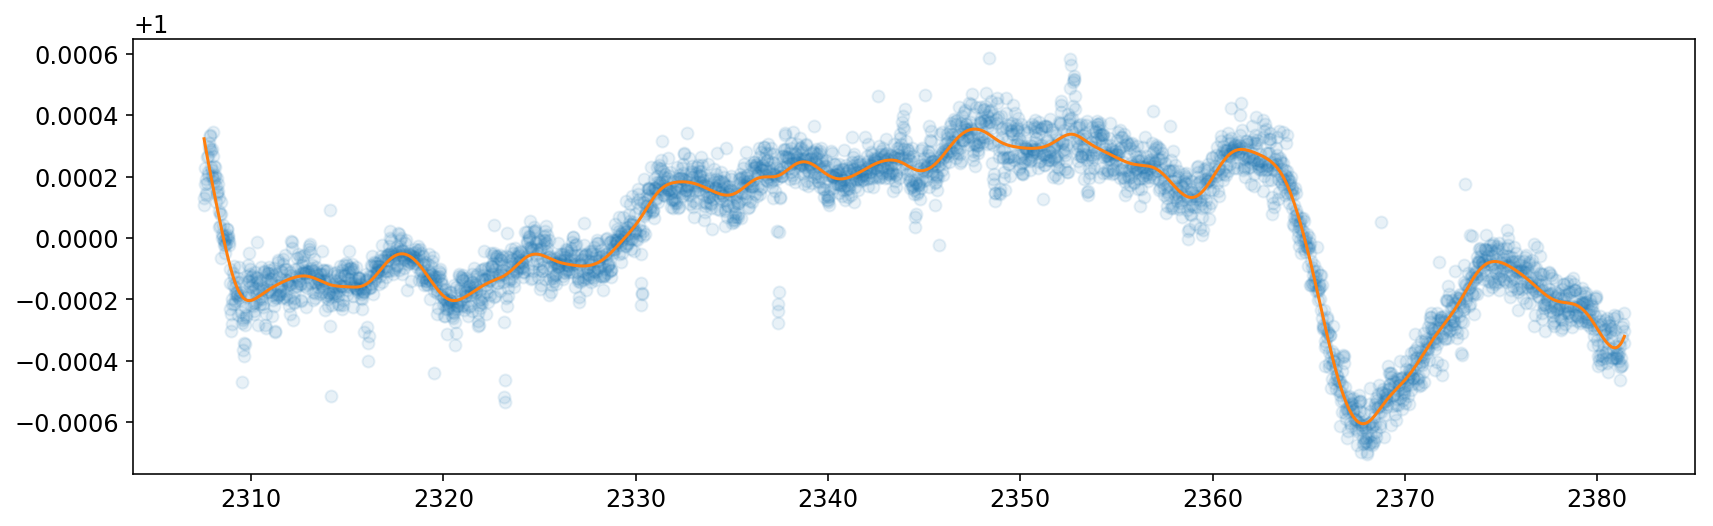

In [45]:
from scipy.interpolate import Rbf
import numpy as np

def rbf(x,y,func='quintic',smooth=0):
    rbfi = Rbf(x, y, function=func,smooth=smooth)  # radial basis function interpolator instance
    return rbfi
    
ff = f_c/np.median(f_c)
rbfi=rbf(t_c,ff,smooth=100)

yhat=rbfi(t_c)

fig = pl.figure(figsize=(14,4))
pl.plot(t_c,ff,'o',alpha=0.1)
pl.plot(t_c,yhat,'-')

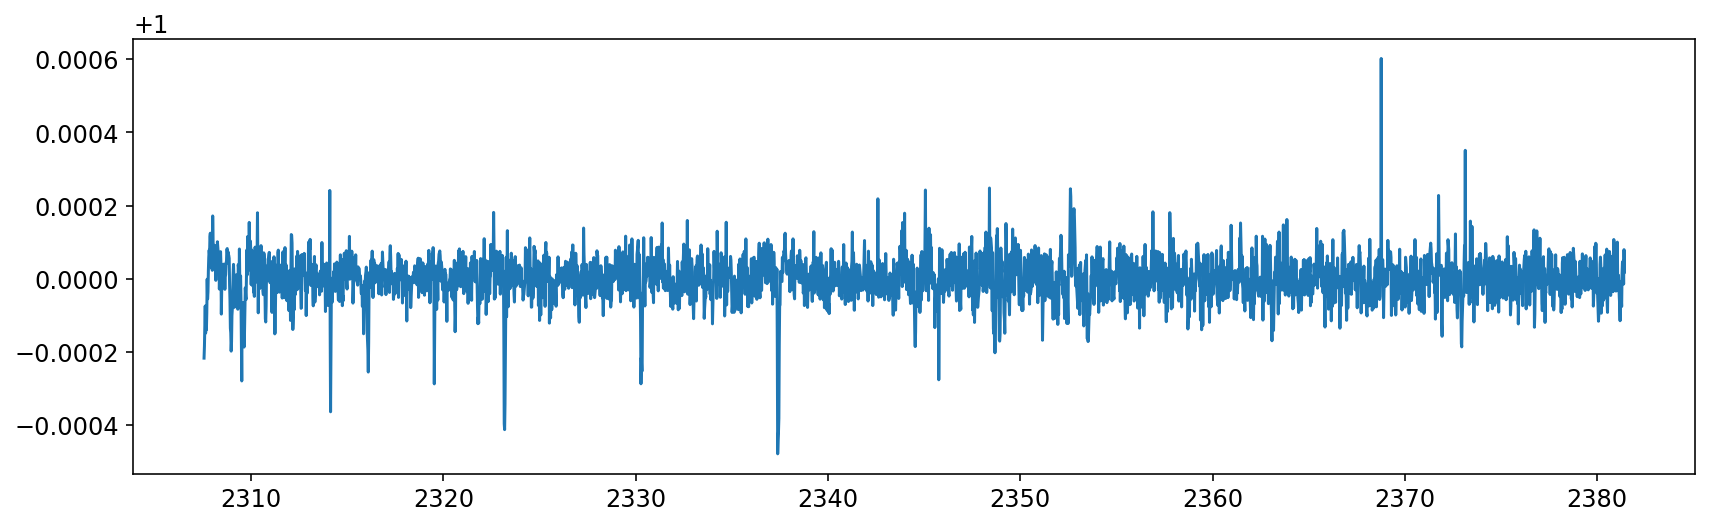

In [46]:
fig = pl.figure(figsize=(14,4))

f_d = ff/yhat
pl.plot(t_c,f_d,'-')

* Period (d) 7.1125241
* Duration (hour) 2.79
* Depth (%) 0.11

Many in-transit data points are removed as outliers. 

[george](http://dfm.io/george/dev/tutorials/first/#first)

## fit high order variability

## find period

In [39]:
import gatspy
from gatspy.periodic import LombScargleFast
   
model = LombScargleFast().fit(t_c, f_d)
periods, power = model.periodogram_auto(nyquist_factor=100)

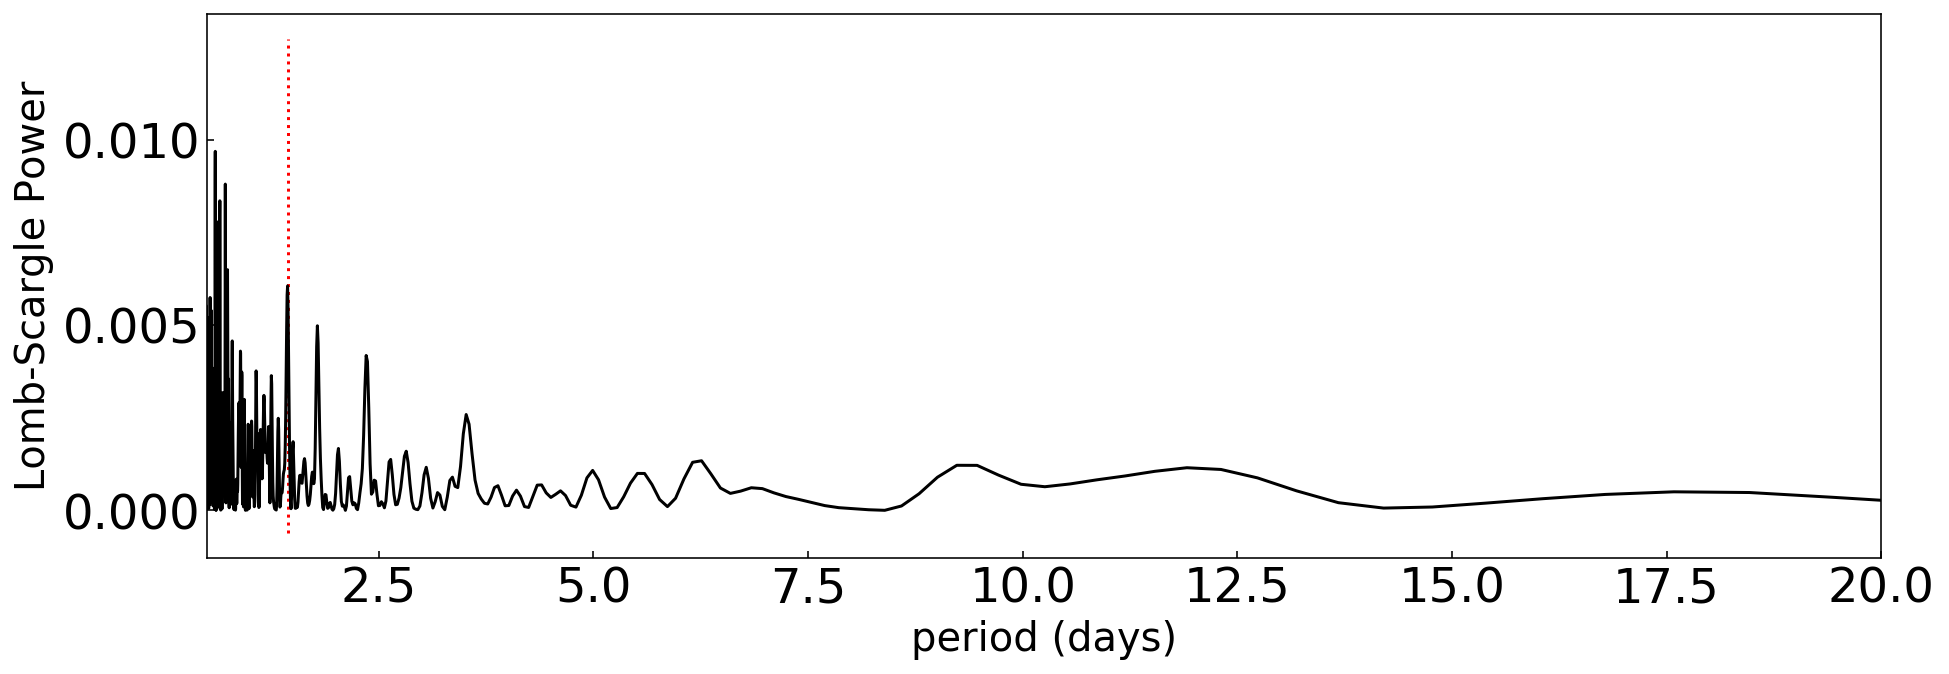

In [40]:
idx1 = periods > 1
idx2 = np.argmax(power[idx1])
peak = periods[idx1][idx2]

fig, ax = pl.subplots(1,1,figsize=(15,5))
ax.plot(periods, power, 'k-')
ax.set(xlim=(0.5, 20),
        #ylim=(0, 0.01),
        xlabel='period (days)',
        ylabel='Lomb-Scargle Power')
ax.vlines(peak, *ax.get_ylim(), linestyles='dotted', colors='r')

In [55]:
peak

1.425883984478766

According to KESPRINT, period is 7.1125241 d

## Phase-folding 

If there are transits/eclipses in a light curve, everest can use the GP prediction to whiten the timeseries and fold it on the period of the planet. If the time of first transit and period of an exoplanet/EB are known, plotting the folded transit/eclipse is easy. Just remember to mask the transit and re-compute the model beforehand:

In [56]:
peak = 7.1

phase = (t_c / peak) % 1

phase_fit = np.linspace(0, 1, 1000)
f_fit = model.predict(peak * phase_fit, period=peak)

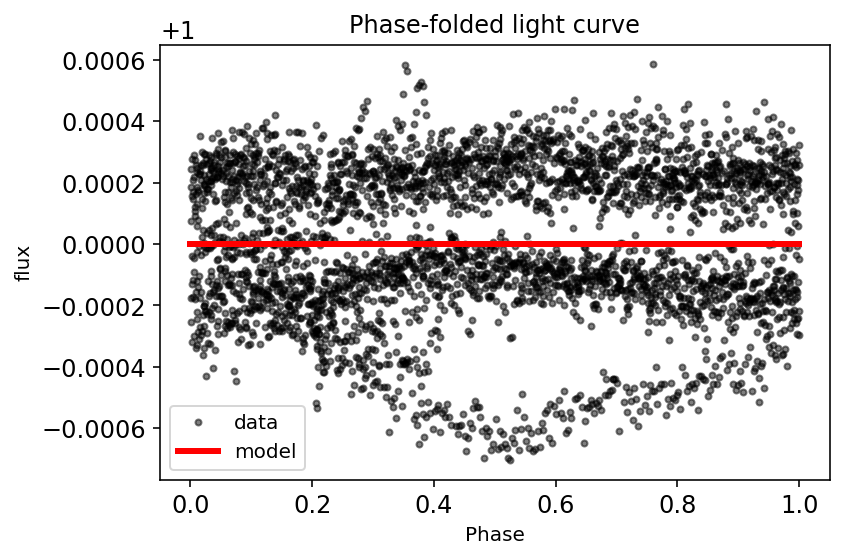

In [57]:
# Plot the phased data & model
fig, ax = pl.subplots()
ax.plot(phase, ff, '.k', alpha=0.5, label='data')
ax.plot(phase_fit, f_fit, '-r', lw=3, label='model')
ax.set(xlabel='Phase', 
       ylabel='flux',
      title='Phase-folded light curve');
ax.legend()

## estimate t0

In [ ]:
idx = (1216.75 < t) & (t < 1217.5)
tsub, fsub = t[idx], f[idx]
idx = fsub < np.median(fsub) - 0.5 * np.std(fsub)
t0 = np.median(tsub[idx])

fig, ax = plt.subplots(1,1,figsize=(15,3))
ax.plot(tsub, fsub, '.')
ax.vlines(t0, *ax.get_ylim())

In [50]:
epic.plot_folded()

## model transit

In [31]:
def baseline(theta, t):
    ti = t - t.mean()
    c0,c1,c2,c3 = theta
    return c0 + c1 * ti + c2 * ti**2 + c3 * ti**3



def obj(theta, t, y, err, order=10):
    yhat = evaluate(theta, t, order=order)
    chi2 = ((y - yhat)/err)**2
    return np.sum(chi2)

In [32]:
order = 10
vecs = [ti**i for i in range(order)]

#normalize flux
ff = f_c/np.median(f_c)
w,X = compute_w(vecs,ff)

initial = np.copy(w)

e = epic.fraw_err
e_c = epic.apply_mask(t)

#normalize flux
args = (t_c, ff, e_c)

n_obj = lambda *args: -obj(*args)

import scipy.optimize as op

opt = op.minimize(n_obj, initial, args=args, method='nelder-mead')
print(opt.success)
print(opt.x)

False
[ 4.30244035e+43  4.58298167e+38  1.15319568e+36 -8.39266360e+35
 -5.73652872e+34 -2.22240120e+33 -4.74622359e+31 -7.83873586e+30
  1.31848562e+26 -1.71891924e+26]


In [137]:
from pytransit import MandelAgol

MA = MandelAgol()


def model(theta, t):
    
    k,t0,p,a,i,u1,u2,_,_,_,_,_ = theta
    model = MA.evaluate(t, k, (u1,u2), t0, p, a, i)
    
    return model
    
    
def lnlike(theta, t, f):
    
    k,t0,p,a,i,u1,u2,sig,c0,c1,c2,c3 = theta
    m = model(theta, t) + baseline(theta, t)
    resid = f - m
    inv_sigma2 = 1.0/(sig**2)

    return -0.5*(np.sum((resid)**2*inv_sigma2 - np.log(inv_sigma2)))


def lnprob(theta, t, f):
    #prior
    if np.any(theta[:-4] < 0):
        return -np.inf
    if theta[4] > np.pi/2.:
        return -np.inf
    #loglike
    ll = lnlike(theta, t, f)
    return ll if np.isfinite(ll) else -np.inf


def scaled_a(p, t14, k, i=np.pi/2.):
    numer = np.sqrt( (k + 1) ** 2 )
    denom = np.sin(i) * np.sin(t14 * np.pi / p)
    return float(numer / denom)

In [ ]:
p = peak
t14 = 0.15
k = np.sqrt(1-0.993)
i = np.pi/2.
a = scaled_a(p, t14, k, i)
u1, u2 = 0.2, 0.2
sig = f.std()
lna = 1e-1
lntau = 1
initial = k,t0,p,a,i,u1,u2,sig,0,0,0,0
args = (t, f)

nlp = lambda *args: -lnprob(*args)

import scipy.optimize as op

opt = op.minimize(nlp, initial, args=args, method='nelder-mead')
print(opt.success)
print(opt.x)

# Appendix